**Problem Statement:**
Using Deep Learning techniques, predict the coordinates (x,y) of a pixel which has a value of 255 for 1 pixel in a given 50x50 pixel grayscale image and all other pixels are 0. You may generate a dataset as required for solving the problem. Please explain your rationale behind dataset choices.

**Submission:**

1. Share your code in a notebook with train logs and graphs showing ground truth and predicted coordinates. Show any result you might find useful.
2. Include any necessary dependencies and installation instructions.
3. Ensure the code follows PEP8 and includes comments where necessary.
4. Submit the assignment via a Git repository or a compressed file.

**Evaluation Criteria:**
1. Functionality: Does the approach used meet the specified prediction requirements?
2. Approach is more important than accuracy.
3. Code Quality: Is the code well-organized, readable, handles errors and maintainable?
4. Does the model do the job as expected?

In [ ]:
import tensorflow as tf
import numpy as np

size = 50

coords = []
labels = []
# Generating coordinates and corresponding labels for a grid of points
for y in range(size):
    for x in range(size):
        coords.append((x, y))
        labels.append((x / (size - 1), y / (size - 1)))  

coords = np.array(coords, dtype=np.int32)       
labels = np.array(labels, dtype=np.float32)      

2026-02-05 14:03:58.429413: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770300238.630777      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770300238.690759      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770300239.215159      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770300239.215198      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770300239.215201      55 computation_placer.cc:177] computation placer alr

In [ ]:
# Function to create an image with a single pixel set to 1.0 at the given coordinates
def make_image(xy):
    x, y = xy[0], xy[1]
    img = tf.zeros((size, size), dtype=tf.float32)
    img = tf.tensor_scatter_nd_update(img,indices=[[y, x]], updates=[1.0])
    return tf.expand_dims(img, axis=-1)

In [ ]:
# Creating a TensorFlow dataset from the coordinates and labels, applying the make_image function to generate images, and preparing it for training and testing
dataset = tf.data.Dataset.from_tensor_slices((coords, labels))
dataset = dataset.map(lambda xy, y: (make_image(xy), y),num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(2500, seed=42) #Shuffling the dataset with a fixed seed for reproducibility

train_size = int(0.8 * 2500)
train_ds = dataset.take(train_size)
test_ds  = dataset.skip(train_size)

train_ds = train_ds.batch(32).prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

print(f"Training samples: {train_size}")
print(f"Testing samples:  {2500 - train_size}")

I0000 00:00:1770300254.094944      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1770300254.101235      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Training samples: 2000
Testing samples:  500


In [ ]:
from tensorflow.keras import layers, models, Input
# Function to create coordinate maps for the given image size
def create_coord_maps(size=50):
    x_range = tf.linspace(0.0, 1.0, size)
    y_range = tf.linspace(0.0, 1.0, size)
    x_map, y_map = tf.meshgrid(x_range, y_range)
    x_map = tf.expand_dims(x_map, axis=-1)
    y_map = tf.expand_dims(y_map, axis=-1)
    return x_map, y_map

# Function to build CoordConv neural network model
def build_coordconv_model2(img_size=50):
    img_input = Input(shape=(img_size, img_size, 1))

    x_map, y_map = create_coord_maps(img_size)

    coords = layers.Lambda(lambda x: tf.tile(
        tf.concat([x_map, y_map], axis=-1)[tf.newaxis, ...],
        [tf.shape(x)[0], 1, 1, 1]
    ))(img_input)

    x = layers.Concatenate()([img_input, coords])
    x = layers.Conv2D(16, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.GlobalMaxPooling2D()(x)
    output = layers.Dense(2, activation="linear")(x)

    return models.Model(img_input, output)

In [ ]:
# Function to compute pixel accuracy based on a tolerance level
def pixel_accuracy(y_true, y_pred, tol=1.0):
    y_true_pix = y_true * (size - 1)
    y_pred_pix = y_pred * (size - 1)

    dist = tf.norm(y_true_pix - y_pred_pix, axis=1)
    return tf.reduce_mean(tf.cast(dist <= tol, tf.float32))

In [ ]:
# Function to compute mean pixel error
def mean_pixel_error(y_true, y_pred):
    y_true_pix = y_true * (size - 1)
    y_pred_pix = y_pred * (size - 1)
    return tf.reduce_mean(tf.norm(y_true_pix - y_pred_pix, axis=1))

In [ ]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)]
model3 = build_coordconv_model2(img_size=50)
model3.compile(optimizer="adamw", loss="mse", metrics=[pixel_accuracy,mean_pixel_error])
# Training the CoordConv model
history3 = model3.fit(train_ds,epochs=100,callbacks=callbacks, validation_data=test_ds,verbose=1)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.1573 - mean_pixel_error: 24.1321 - pixel_accuracy: 0.0011 - val_loss: 0.0494 - val_mean_pixel_error: 13.9669 - val_pixel_accuracy: 0.0039
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0344 - mean_pixel_error: 11.0562 - pixel_accuracy: 0.0191 - val_loss: 0.0063 - val_mean_pixel_error: 3.9390 - val_pixel_accuracy: 0.1637
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0042 - mean_pixel_error: 2.9367 - pixel_accuracy: 0.2800 - val_loss: 0.0011 - val_mean_pixel_error: 1.2697 - val_pixel_accuracy: 0.7437
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011 - mean_pixel_error: 1.2091 - pixel_accuracy: 0.7468 - val_loss: 9.4650e-04 - val_mean_pixel_error: 1.1750 - val_pixel_accuracy: 0.6805
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.7280e-04 - mean_pixel_error: 0.9906 - pixel_accuracy: 0.8067 - val_loss: 3.1933e-04 - val_mean_pixel_error: 0.7676 - val_pixel_accuracy: 0.8711

In [ ]:
predictions3 = model3.predict(test_ds)
# Evaluating the model's performance on unseen pixels
y_true = np.concatenate([y for _, y in test_ds], axis=0)

pred_coords3 = predictions3 * (size - 1)
true_coords3 = y_true * (size - 1)
# Calculating Euclidean distances between predicted and true coordinates
distances3 = np.sqrt(np.sum((pred_coords3 - true_coords3) ** 2, axis=1))
print(f"Average error on unseen pixels: {distances3.mean():.4f} pixels")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Average error on unseen pixels: 26.2055 pixels


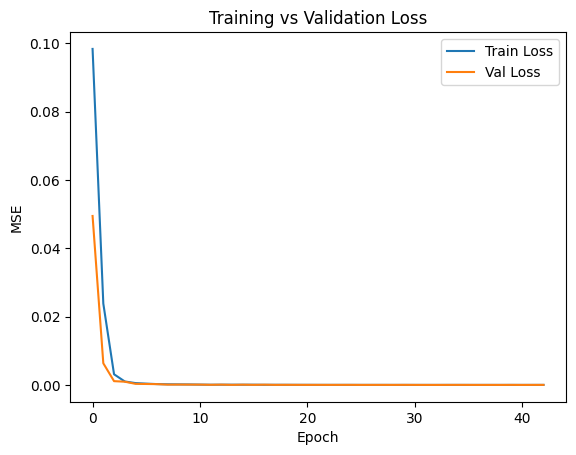

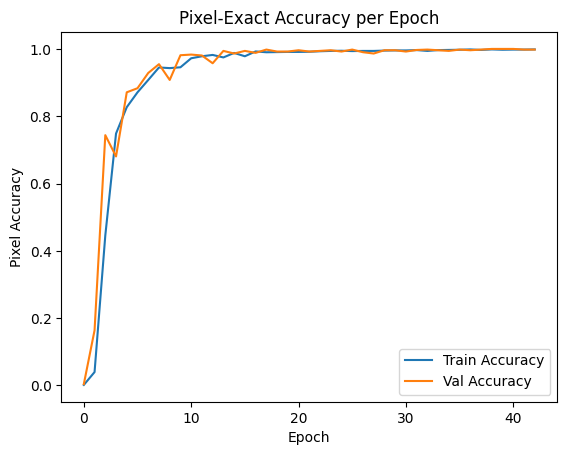

In [ ]:
import matplotlib.pyplot as plt
# Plotting training and validation loss over epochs
plt.figure()
plt.plot(history3.history["loss"], label="Train Loss")
plt.plot(history3.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

# Plotting pixel-exact accuracy over epochs
plt.figure()
plt.plot(history3.history["pixel_accuracy"], label="Train Accuracy")
plt.plot(history3.history["val_pixel_accuracy"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Pixel Accuracy")
plt.legend()
plt.title("Pixel-Exact Accuracy per Epoch")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
# Generating confusion matrix for pixel-level predictions
y_true_all = []
y_pred_all = []

for imgs, y_true in test_ds:
    preds = model3.predict(imgs, verbose=0)
    
    y_true_pix = np.round(y_true.numpy() * (size - 1)).astype(int)
    y_pred_pix = np.round(preds * (size - 1)).astype(int)

    true_ids = y_true_pix[:, 1] * size + y_true_pix[:, 0]
    pred_ids = y_pred_pix[:, 1] * size + y_pred_pix[:, 0]

    y_true_all.extend(true_ids)
    y_pred_all.extend(pred_ids)

cm = confusion_matrix(y_true_all,y_pred_all,labels=np.arange(size * size))

print("Confusion matrix shape:", cm.shape)

Confusion matrix shape: (2500, 2500)


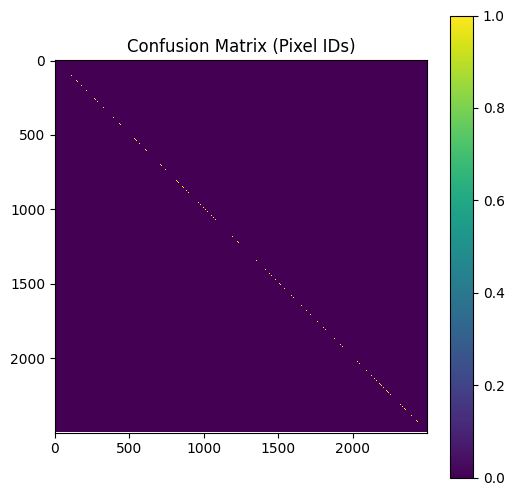

In [ ]:
# Plotting the confusion matrix as heatmap
plt.figure(figsize=(6, 6))
plt.imshow(cm, cmap="viridis", interpolation="nearest")
plt.title("Confusion Matrix (Pixel IDs)")
plt.colorbar()
plt.show()